In [1]:
# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

# - Rockpool imports
from rockpool import TSEvent, TSContinuous
from rockpool.nn.modules import LIFJax, LinearJax, ExpSynJax
from rockpool.nn.modules.jax.jax_lif_ode import LIFODEJax
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Typing
from typing import Callable, Dict, Tuple
import types

# - Numpy
import numpy as np
import copy

# - Pretty printing
try:
    from rich import print
except:
    pass

# TQDM
from tqdm.autonotebook import tqdm

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

In [2]:
# - Define input and target
Nin = 200
dt = 1e-3
chirp_freq_factor = 10
dur_input = 1000e-3

# - Generate a time base
T = int(np.round(dur_input / dt))
timebase = np.linspace(0, (T-1) * dt, T)

# - Generate a chirp signal as a target
chirp = np.atleast_2d(np.sin(timebase * 2 * np.pi * (timebase * chirp_freq_factor))).T

chirp.shape

(1000, 1)

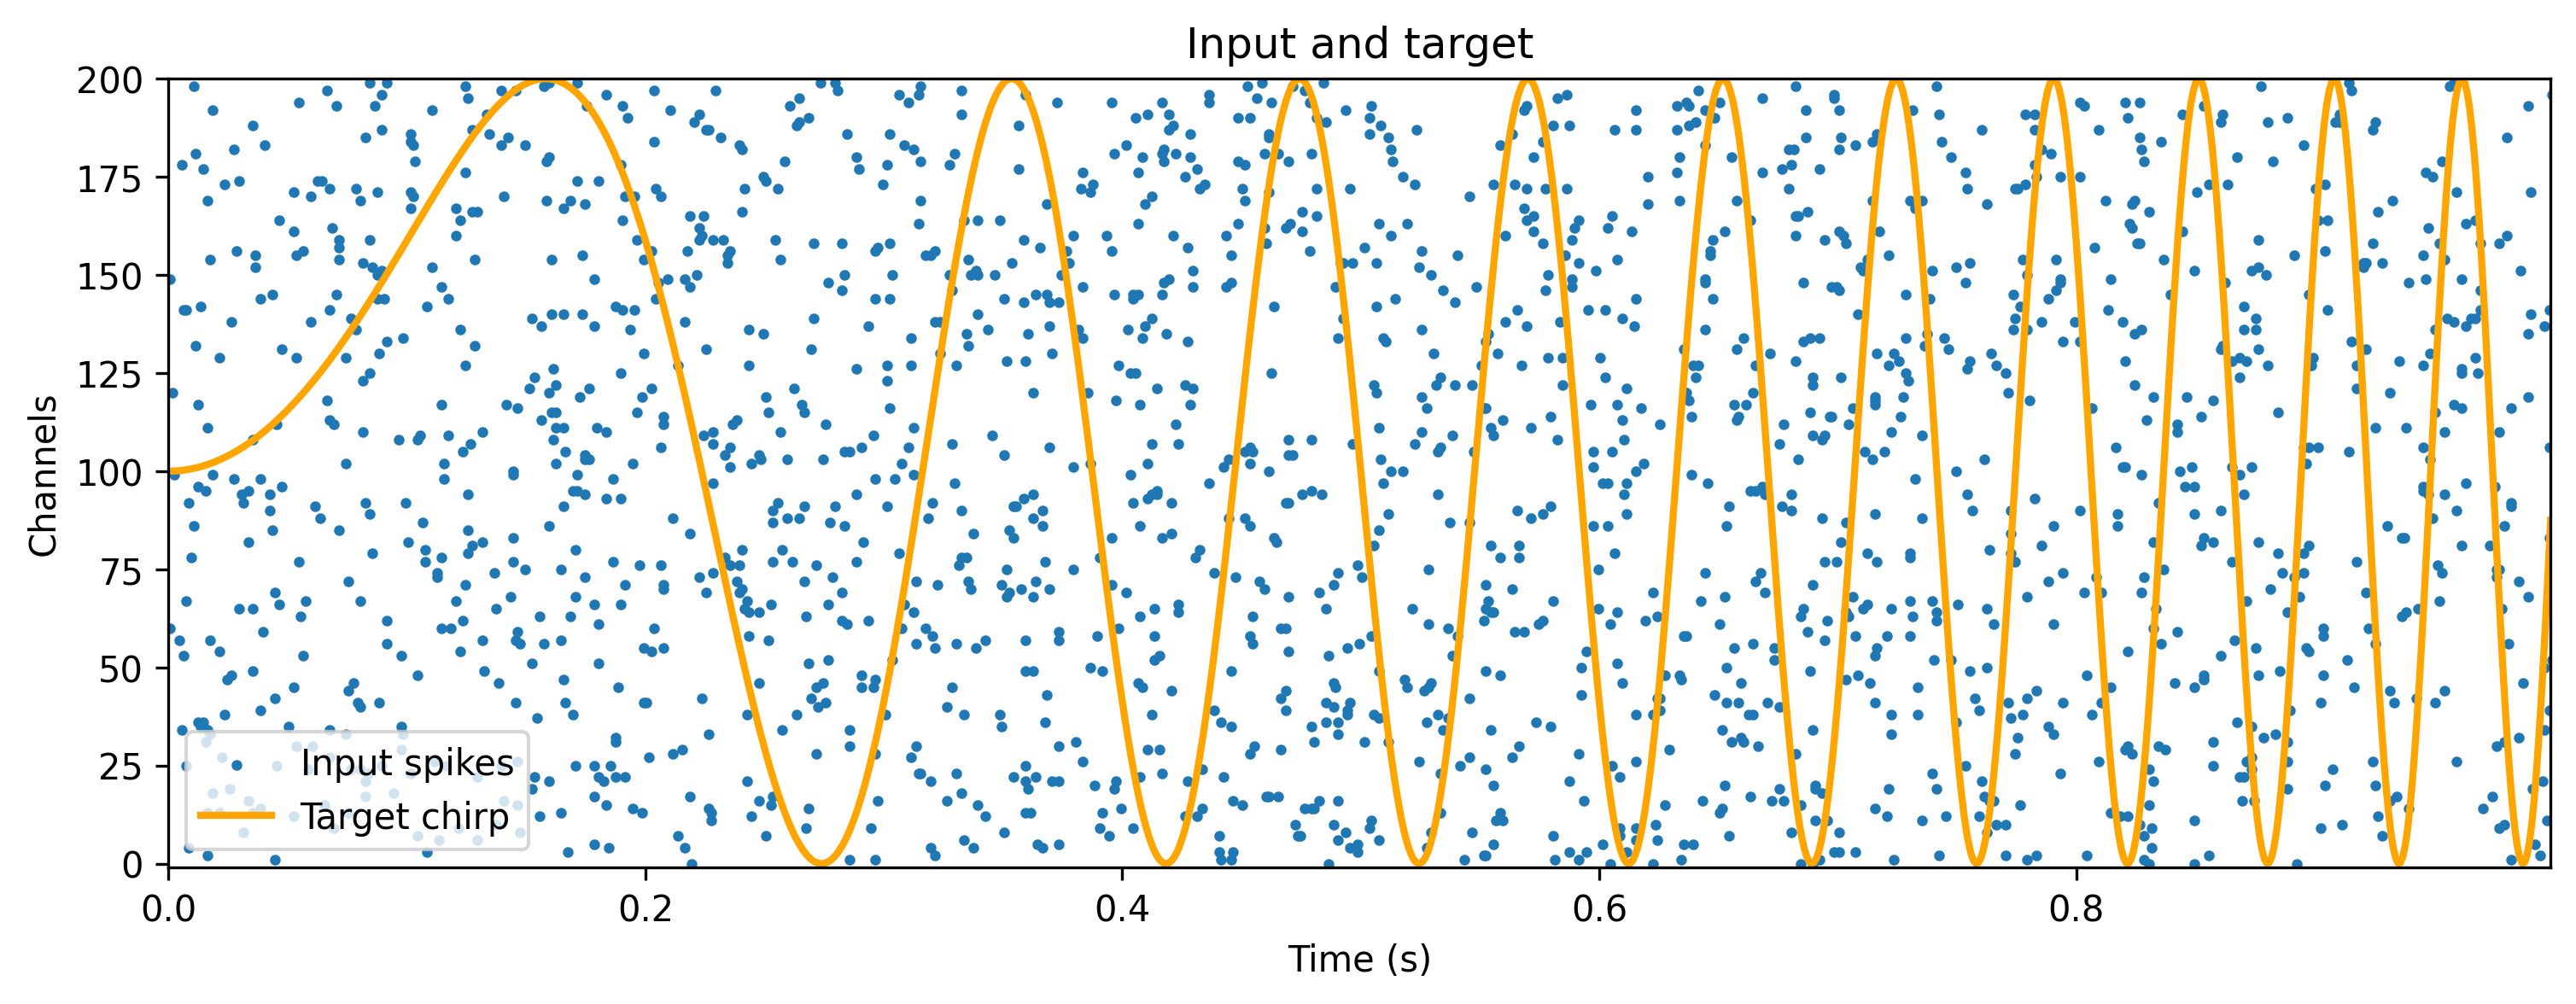

In [3]:
target_ts = TSContinuous(timebase, chirp, periodic = True, name = 'Target chirp')

# - Generate a Poisson frozen random spike train
spiking_prob = .01
input_sp_raster = np.random.rand(T, Nin) < spiking_prob
input_sp_ts = TSEvent.from_raster(input_sp_raster, name = 'Input spikes', periodic = True, dt = dt)

# - Plot the input and target signals
plt.figure()
input_sp_ts.plot(s = 4)
(target_ts * Nin/2 + Nin/2).plot(color="orange", lw=2)
plt.legend()
plt.title('Input and target');

In [4]:
# - Network size
N = 50
Nout = 1
input_scale = 20.

In [5]:
# - Generate a network using the sequential combinator
modFFwd = Sequential(
    LinearJax((Nin, N), has_bias = False),
    LIFODEJax(N, dt = dt),
    ExpSynJax(N),
    LinearJax((N, Nout)),
)

print(modFFwd)

JaxSequential  with shape (200, 1) {
    LinearJax '0_LinearJax' with shape (200, 50)
    LIFODEJax '1_LIFODEJax' with shape (50, 50)
    ExpSynJax '2_ExpSynJax' with shape (50,)
    LinearJax '3_LinearJax' with shape (50, 1)
}


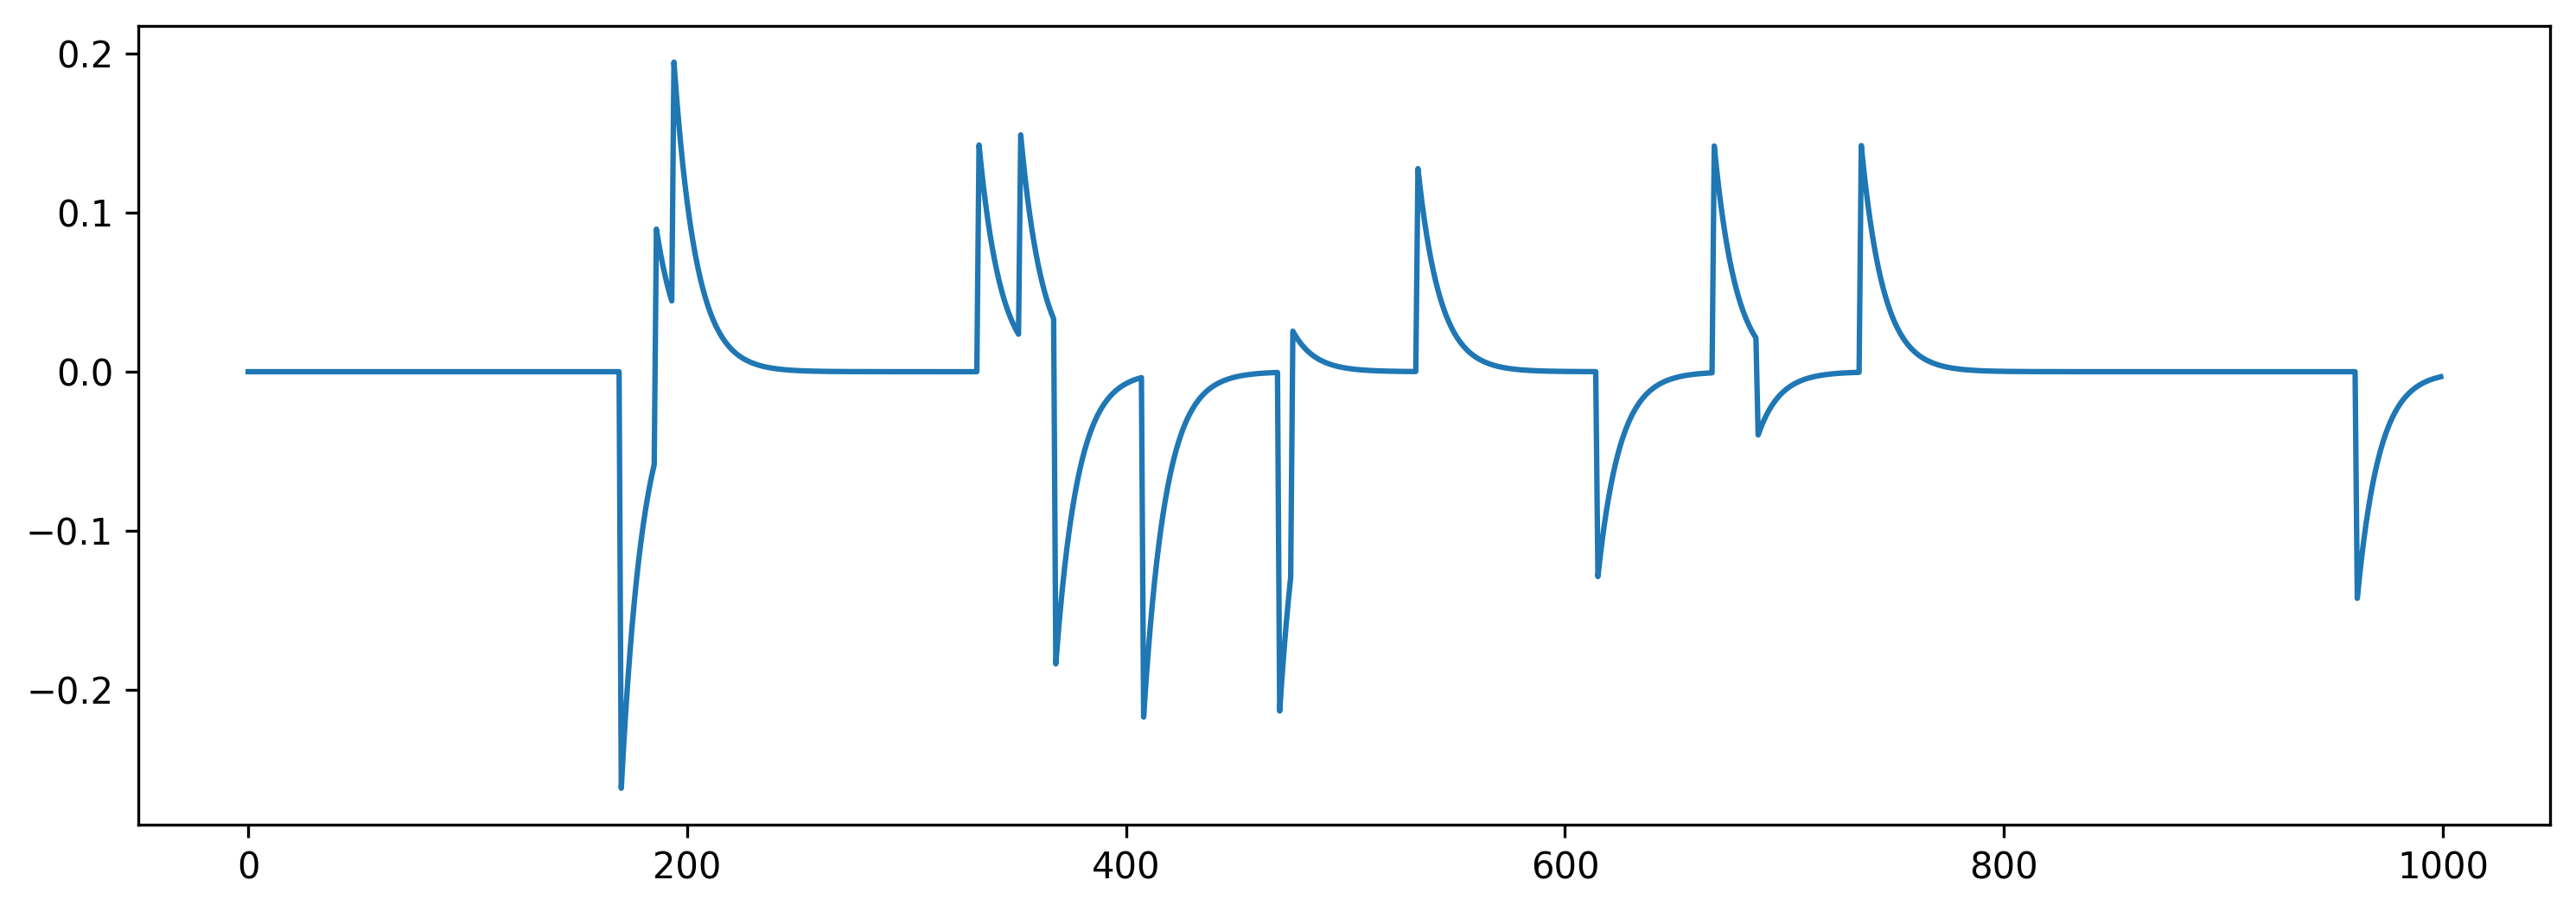

In [6]:
# - Randomise the network state
modFFwd.reset_state()

# - Evolve with the frozen noise spiking input
tsOutput, new_state, record_dict = modFFwd(input_sp_raster * input_scale, record = True)

# - Plot the analog output
plt.figure()
plt.plot(tsOutput[0])

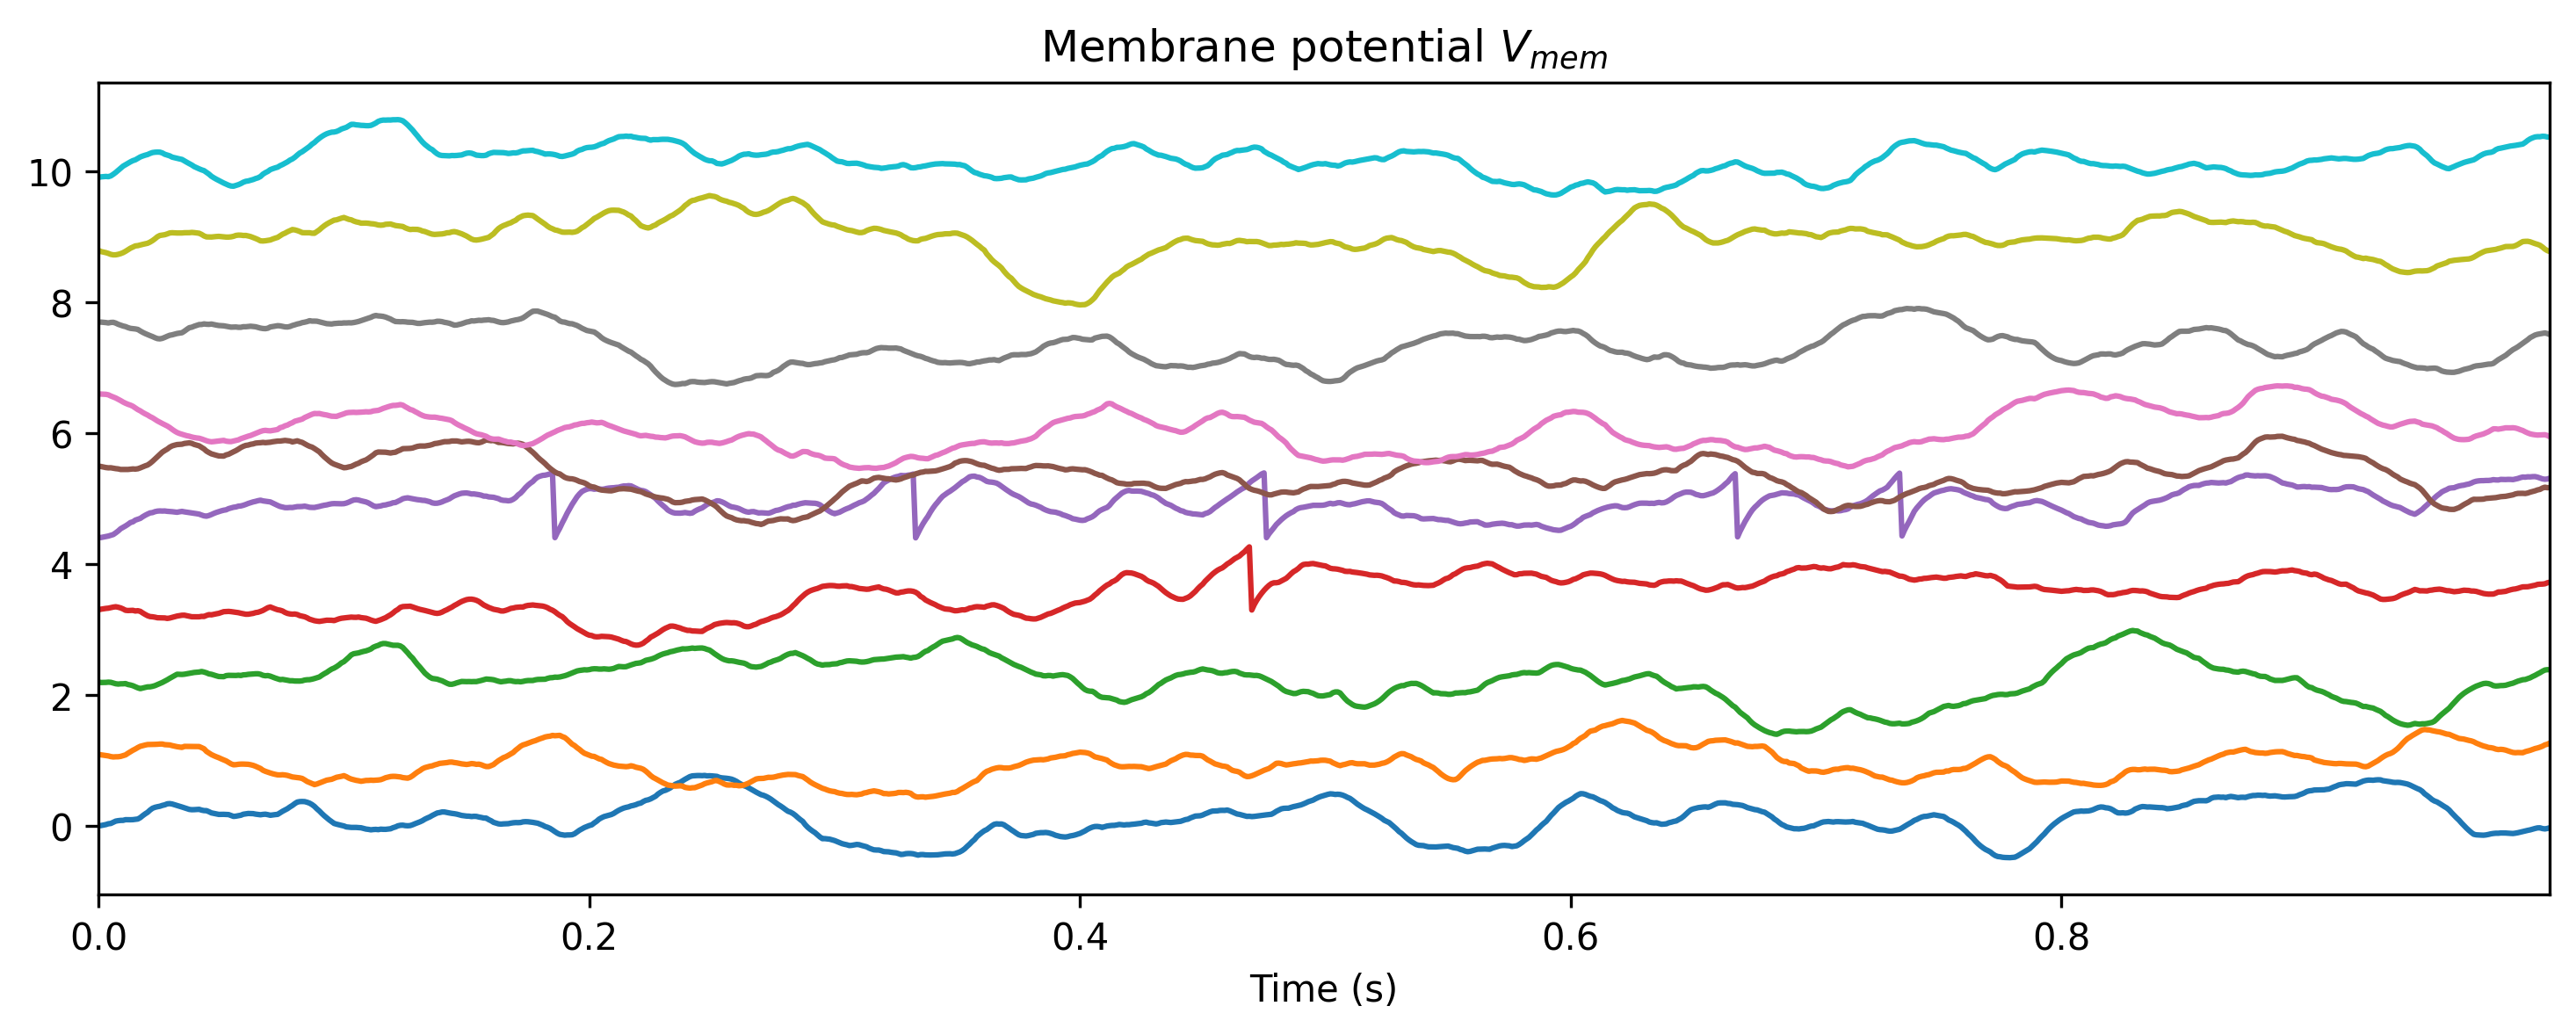

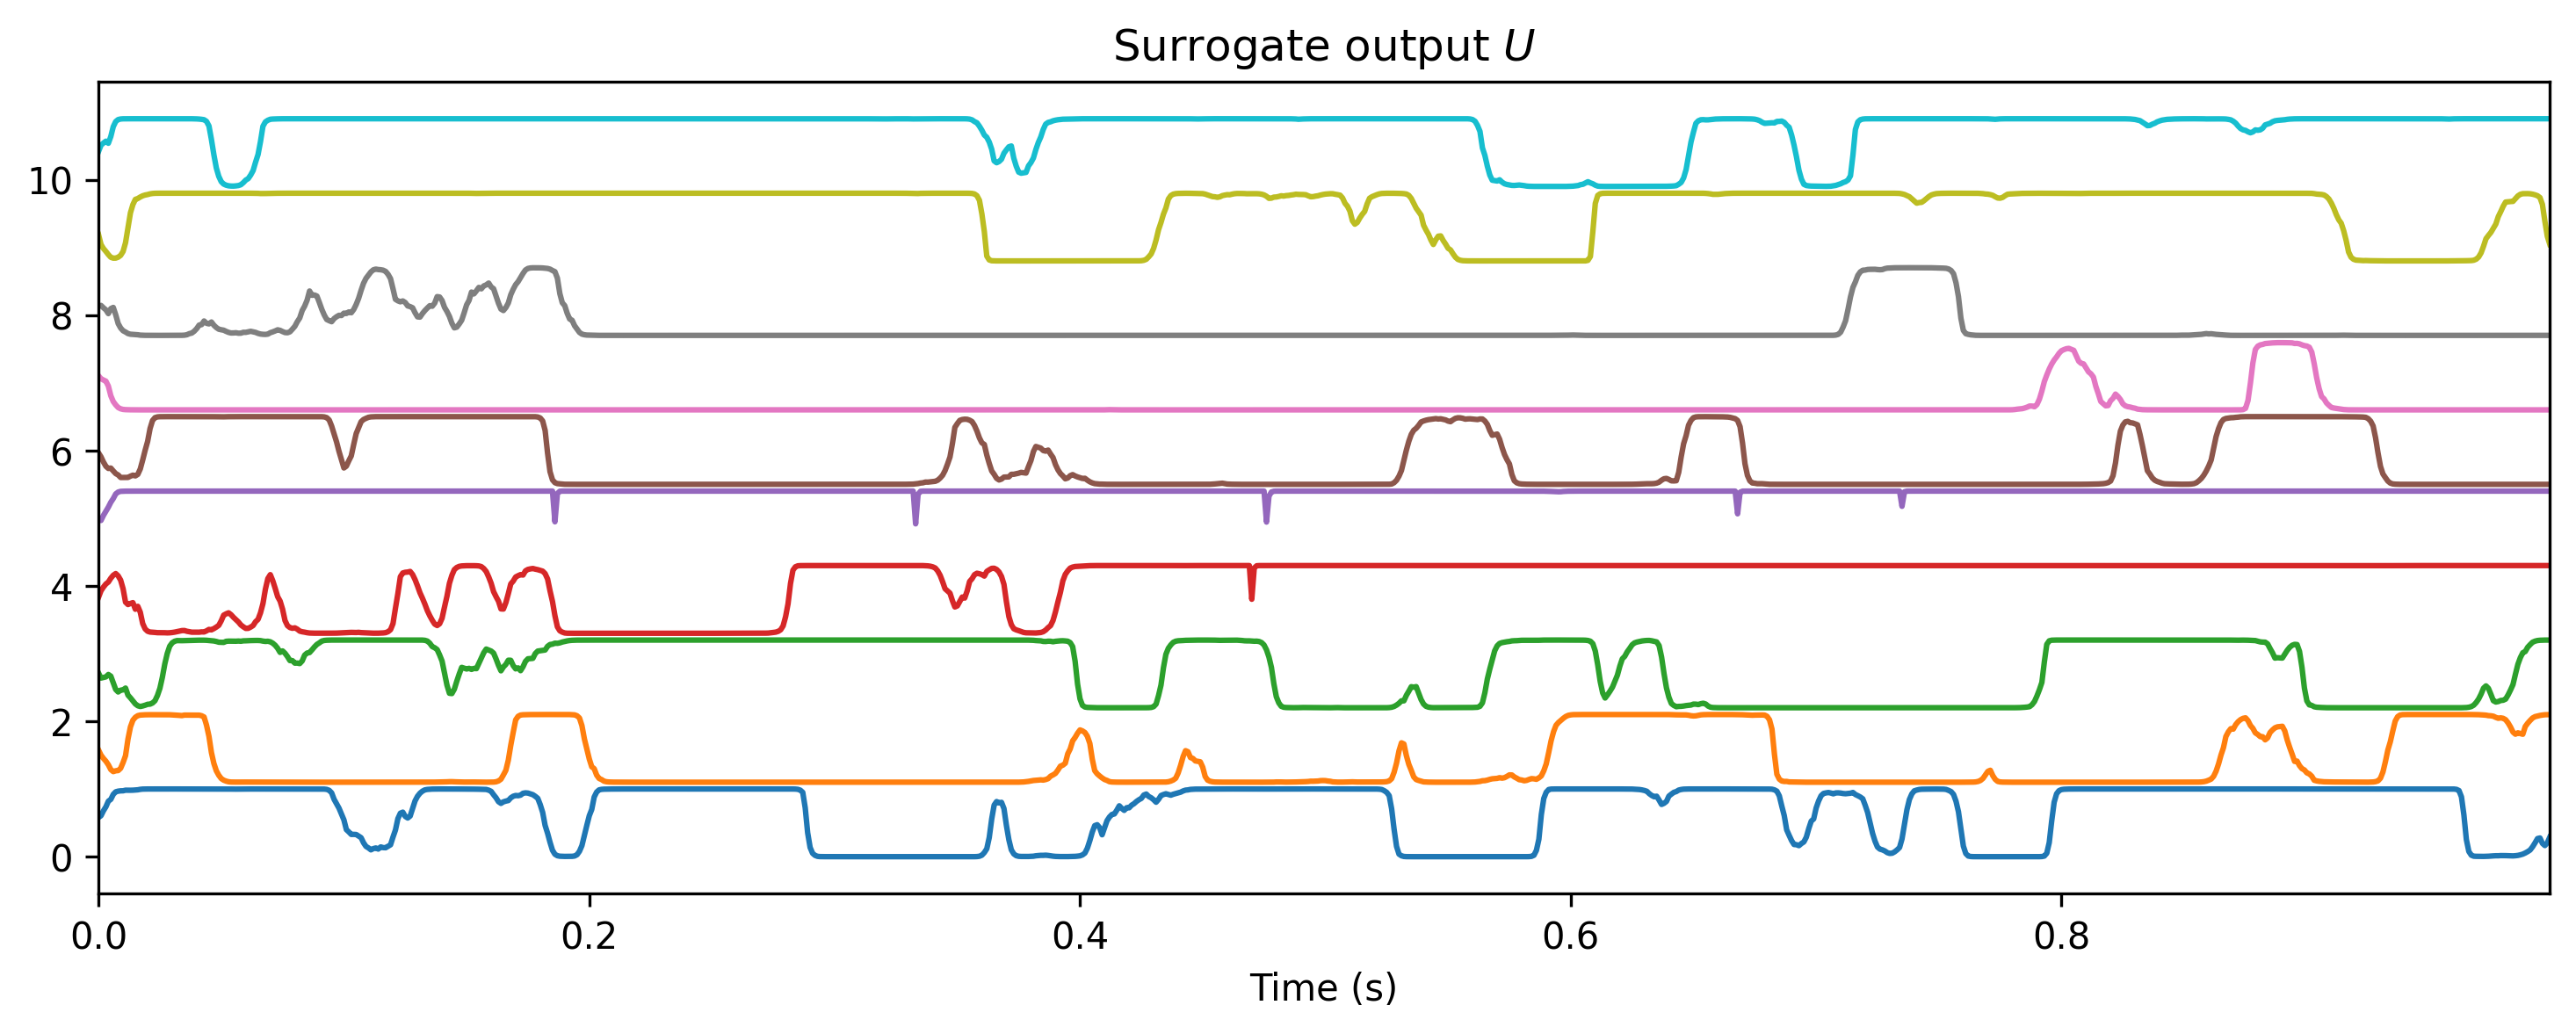

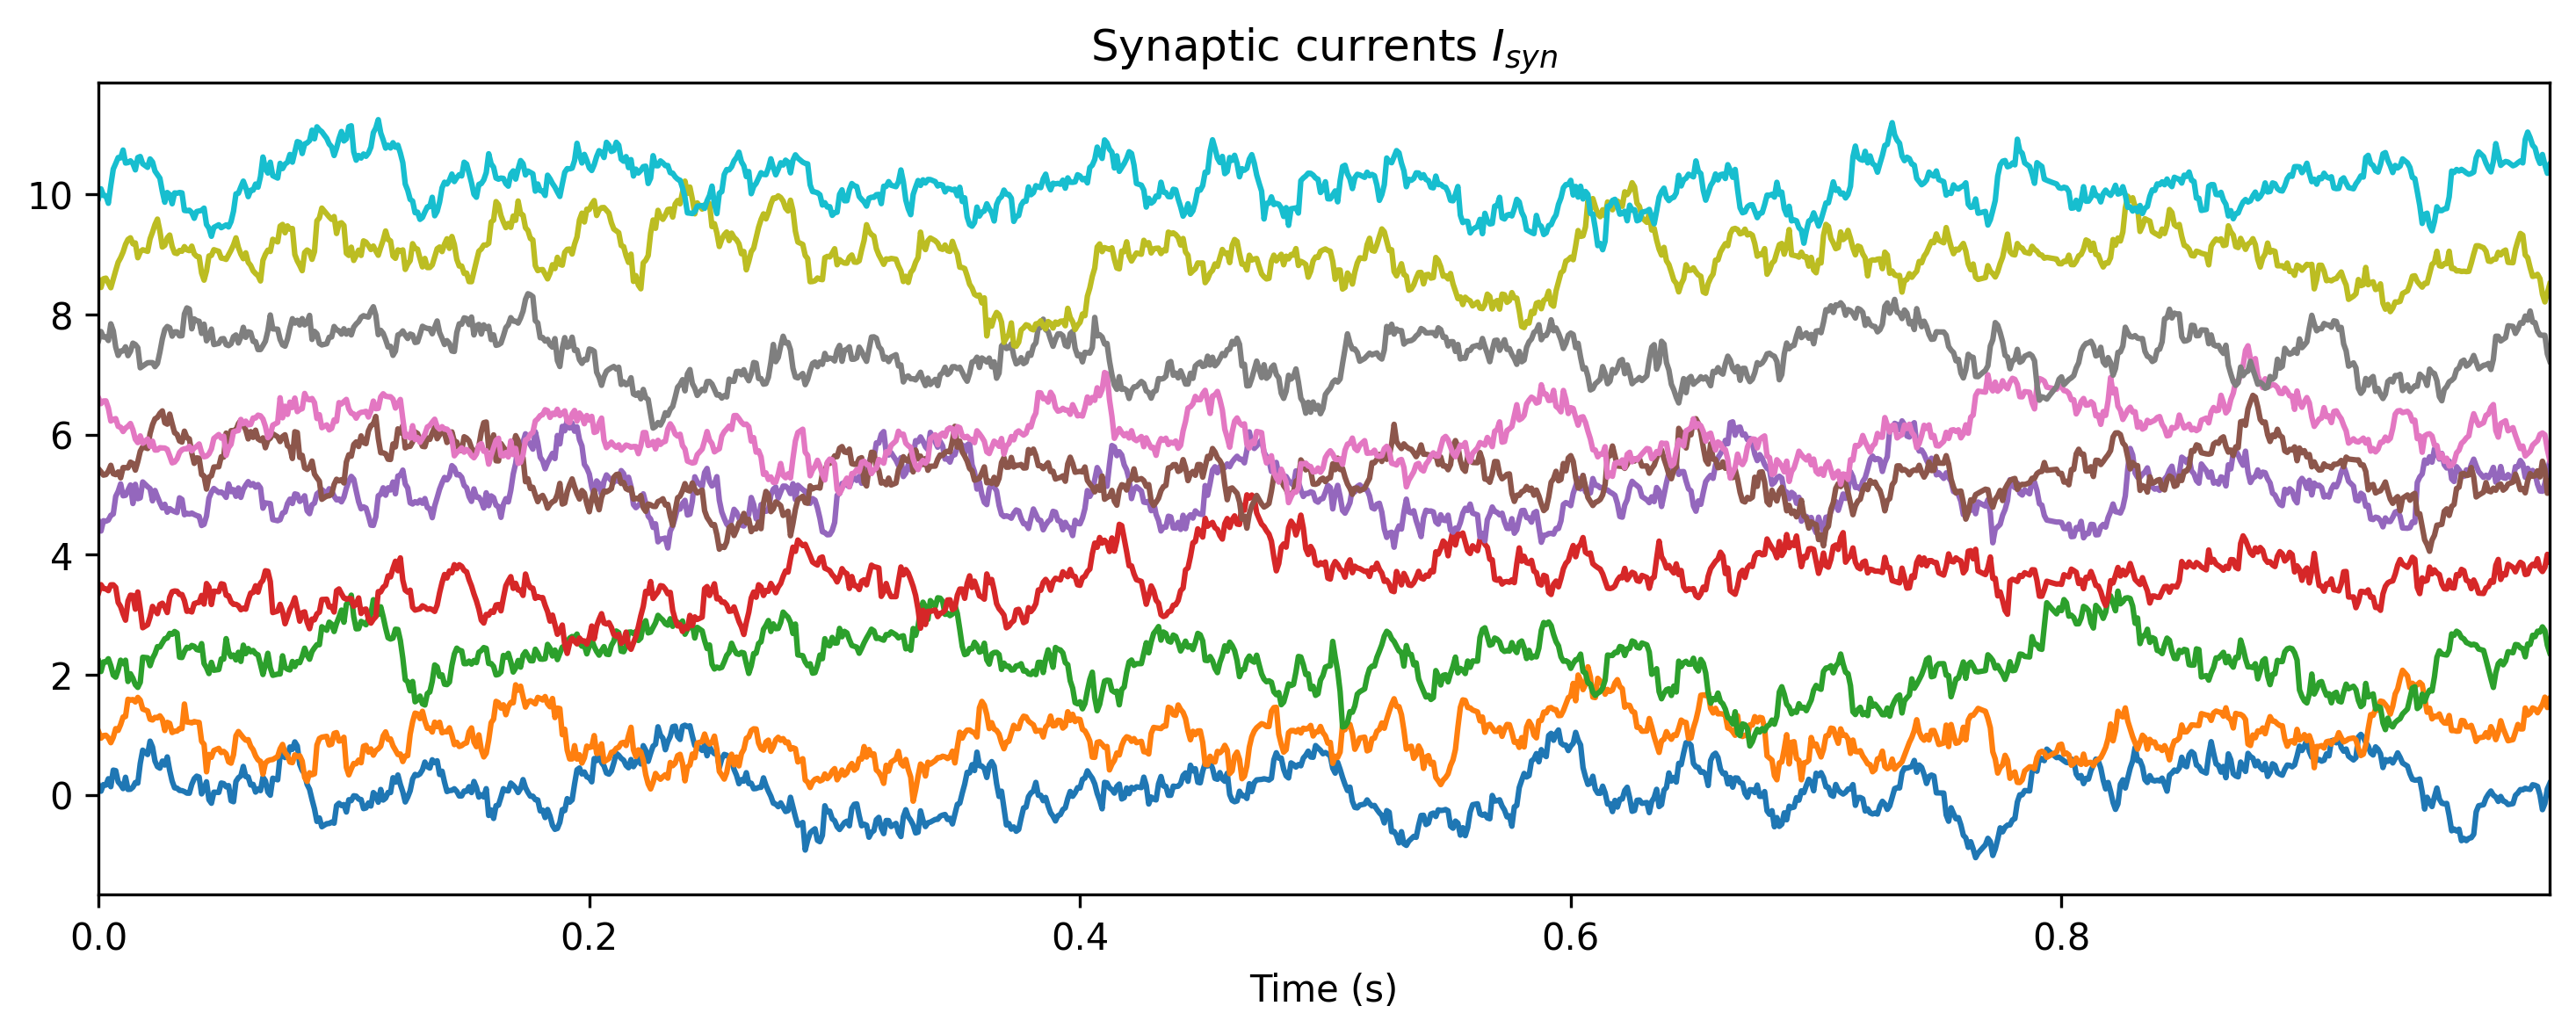

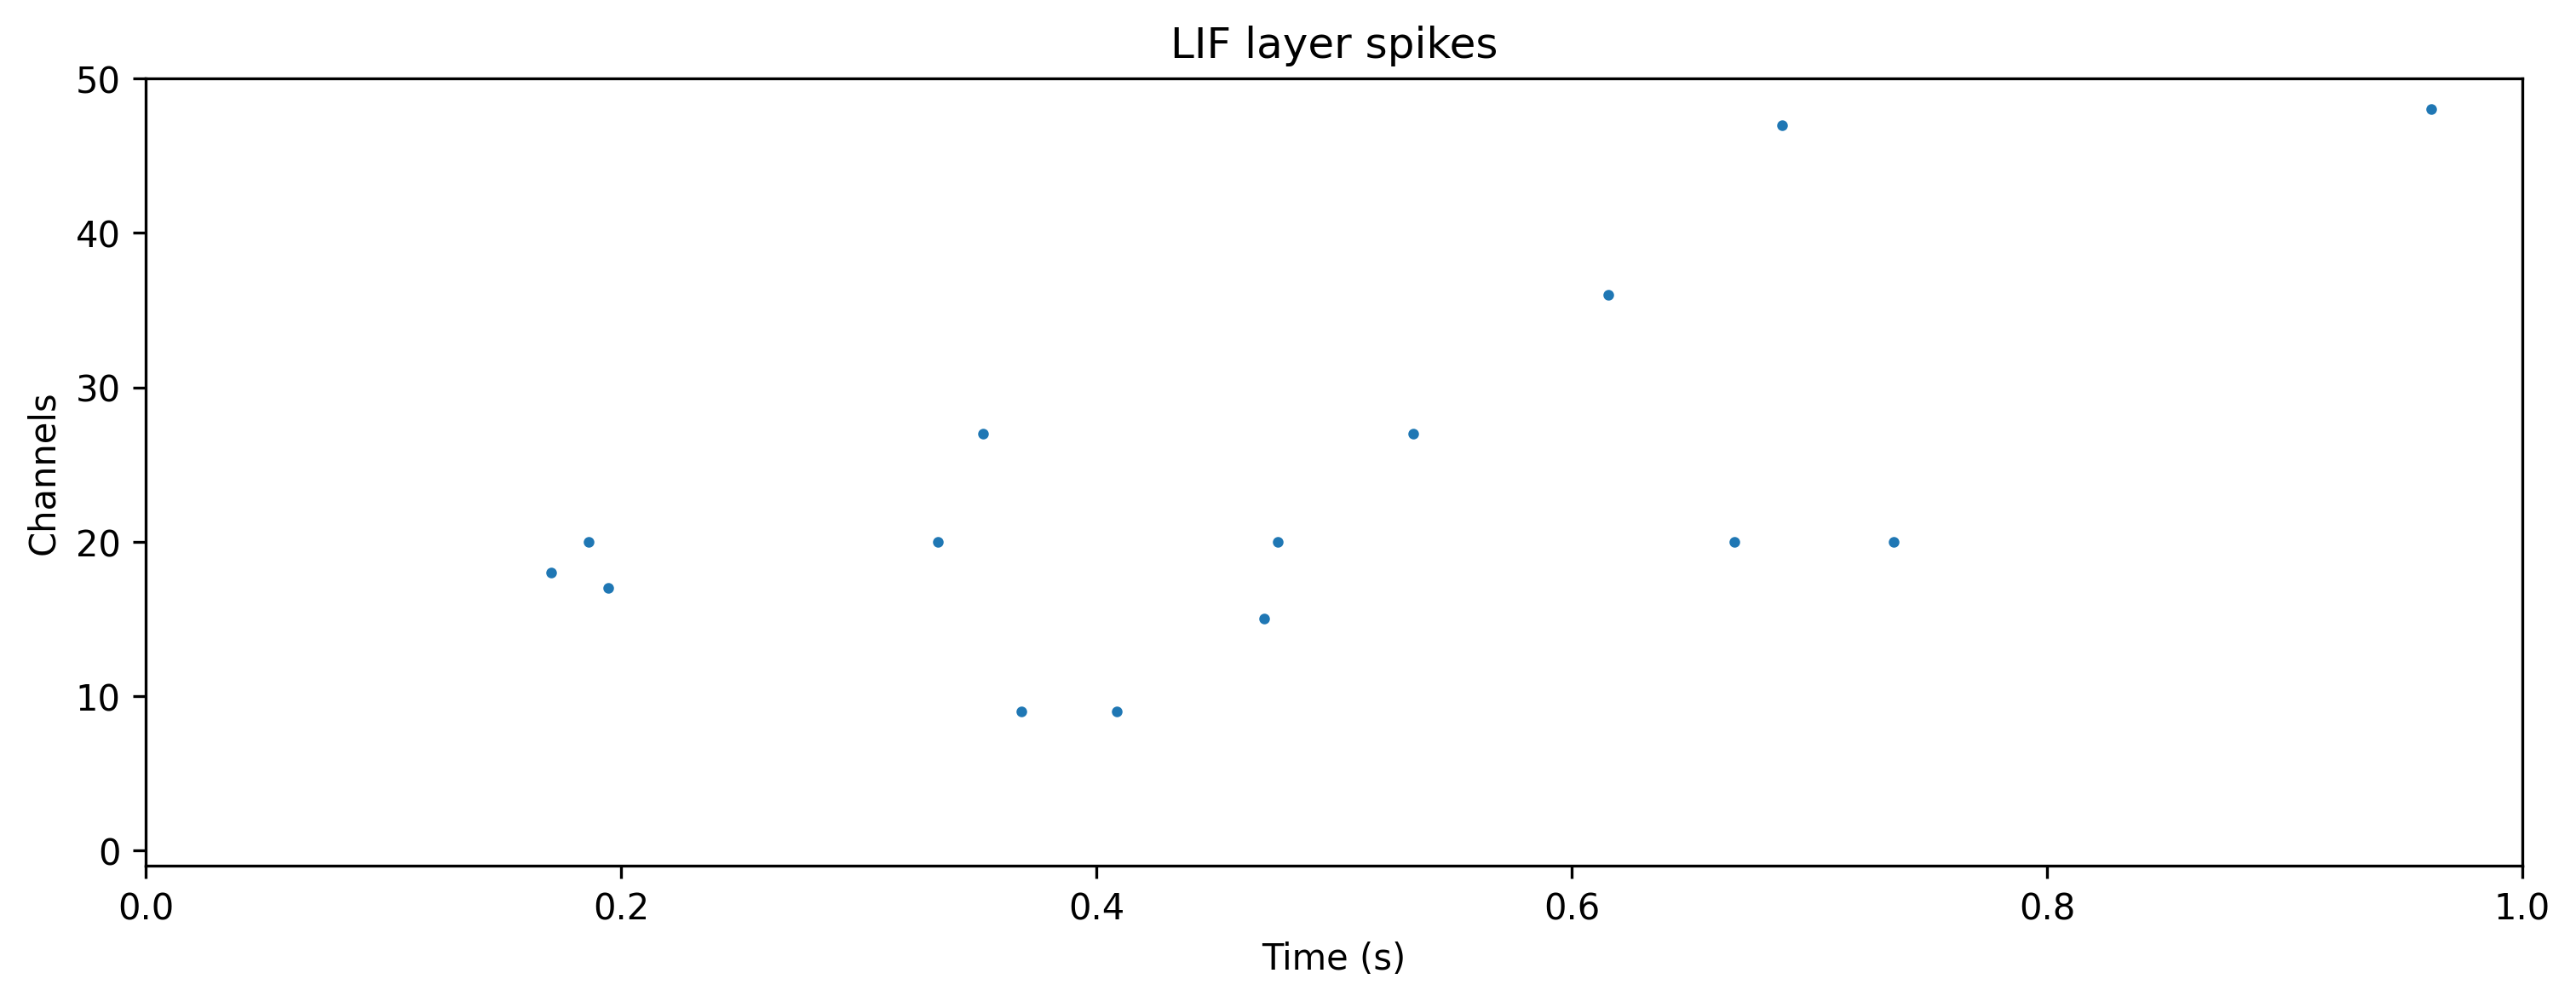

In [7]:
# - Make a function that converts ``record_dict``
def plot_record_dict(rd):
    Vmem_ts = TSContinuous.from_clocked(rd['1_LIFODEJax']['vmem'][0], dt, name = 'Membrane potential $V_{mem}$')
    U_ts = TSContinuous.from_clocked(rd['1_LIFODEJax']['U'][0], dt, name = 'Surrogate output $U$')
    Isyn_ts = TSContinuous.from_clocked(rd['1_LIFODEJax']['isyn'][0, :, :, 0], dt, name = 'Synaptic currents $I_{syn}$')
    spikes_ts = TSEvent.from_raster(rd['1_LIFODEJax']['spikes'][0], dt, name = 'LIF layer spikes')

    # - Plot the internal activity of selected neurons
    plt.figure()
    Vmem_ts.plot(stagger = 1.1, skip = 5)

    plt.figure()
    U_ts.plot(stagger = 1.1, skip = 5)

    plt.figure()
    Isyn_ts.plot(stagger = 1.1, skip = 5)

    plt.figure()
    spikes_ts.plot(s=4);

plot_record_dict(record_dict)

In [8]:
# - Import the convenience functions
from rockpool.training.jax_loss import bounds_cost, make_bounds

# - Generate a set of pre-configured bounds
lower_bounds, upper_bounds = make_bounds(modFFwd.parameters())
print('lower_bounds: ', lower_bounds,
      'upper_bounds: ', upper_bounds)

lower_bounds:  {'0_LinearJax': {'weight': -inf}, '1_LIFODEJax': {'bias': -inf, 'tau_mem': -inf, 'tau_syn': -inf, 'threshold': -inf}, '2_ExpSynJax': {'tau': -inf}, '3_LinearJax': {'weight': -inf}} upper_bounds:  {'0_LinearJax': {'weight': inf}, '1_LIFODEJax': {'bias': inf, 'tau_mem': inf, 'tau_syn': inf, 'threshold': inf}, '2_ExpSynJax': {'tau': inf}, '3_LinearJax': {'weight': inf}}


In [9]:
# - Impose a lower bound for the time constants
lower_bounds['1_LIFODEJax']['tau_syn'] = 11 * dt
lower_bounds['1_LIFODEJax']['tau_mem'] = 11 * dt
# lower_bounds['1_LIFODEJax']['threshold'] = 0.1
lower_bounds['2_ExpSynJax']['tau'] = 11 * dt

In [10]:
import rockpool.training.jax_loss as l
import jax.numpy as jnp

# - Define a loss function
def loss_mse(params, net, input, target):
    # - Reset the network state
    net = net.reset_state()

    # - Apply the parameters
    net = net.set_attributes(params)

    # - Evolve the network
    output, _, states = net(input, record = True)

    # - Impose the bounds
    bounds = bounds_cost(params, lower_bounds, upper_bounds)

    # - Return the loss
    return l.mse(output, target) + 100.* bounds

In [13]:
# - Useful imports
from tqdm.autonotebook import tqdm
from copy import deepcopy
from itertools import count

# -- Import an optimiser to use and initalise it
import jax
from jax.example_libraries.optimizers import adam

# - Get the optimiser functions
init_fun, update_fun, get_params = adam(1e-4)

# - Initialise the optimiser with the initial parameters
params0 = copy.deepcopy(modFFwd.parameters())
opt_state = init_fun(modFFwd.parameters())

# - Get a compiled value-and-gradient function
loss_vgf = jax.jit(jax.value_and_grad(loss_mse))

# - Compile the optimiser update function
update_fun = jax.jit(update_fun)

# - Record the loss values over training iterations
loss_t = []
grad_t = []

num_epochs = 2000

In [23]:
# - Loop over iterations
i_trial = count()
for _ in tqdm(range(num_epochs)):
    # - Get parameters for this iteration
    params = get_params(opt_state)

    # - Get the loss value and gradients for this iteration
    loss_val, grads = loss_vgf(params, modFFwd, input_sp_raster * input_scale, chirp)

    # - Update the optimiser
    opt_state = update_fun(next(i_trial), grads, opt_state)

    # - Keep track of the loss
    loss_t.append(loss_val)

  0%|          | 0/2000 [00:00<?, ?it/s]

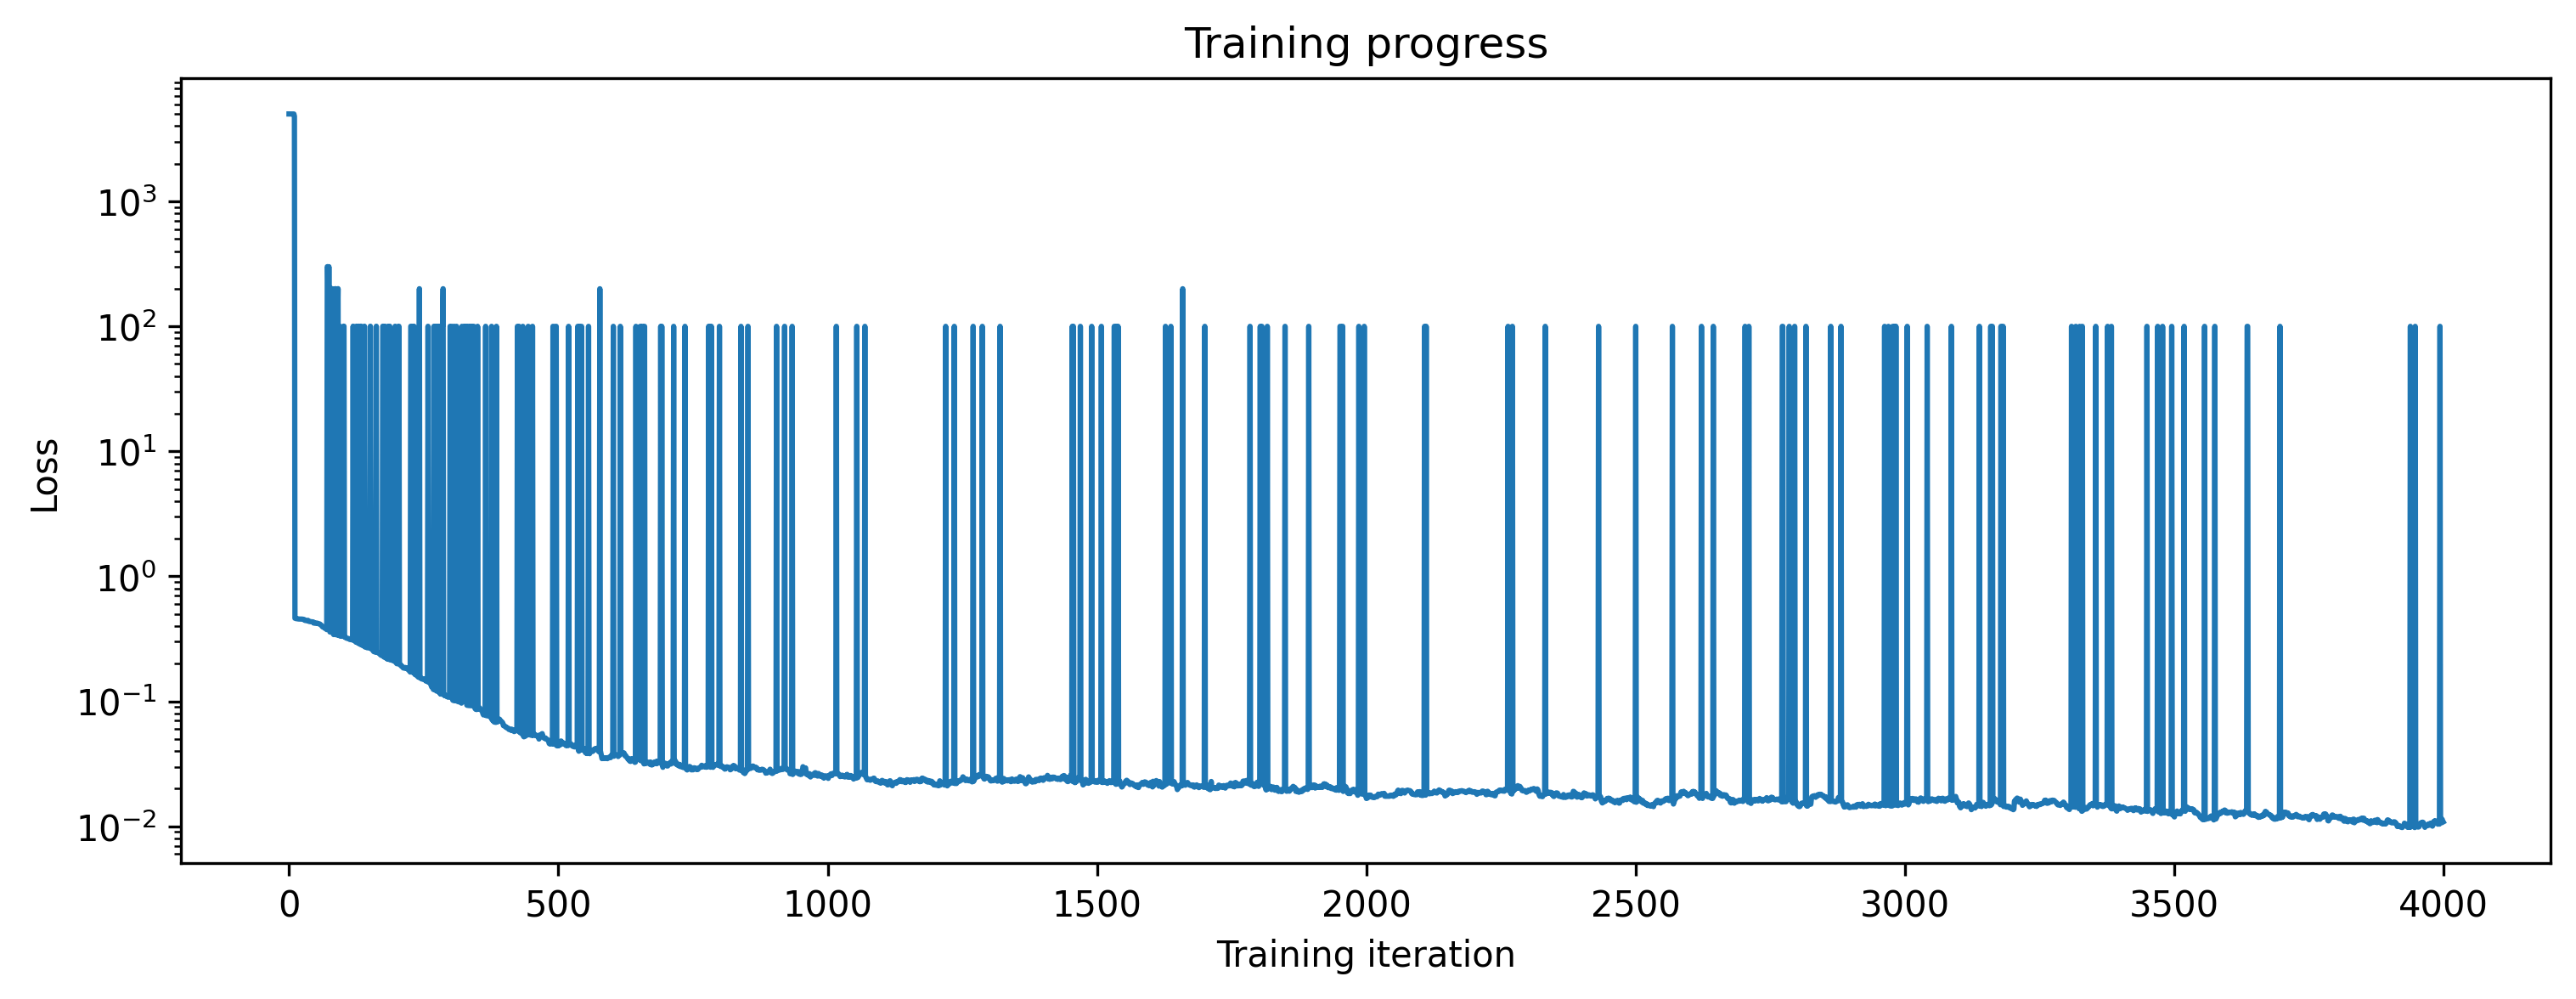

In [24]:
# - Plot the loss
plt.figure()
plt.plot(loss_t)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training iteration');
plt.title('Training progress');

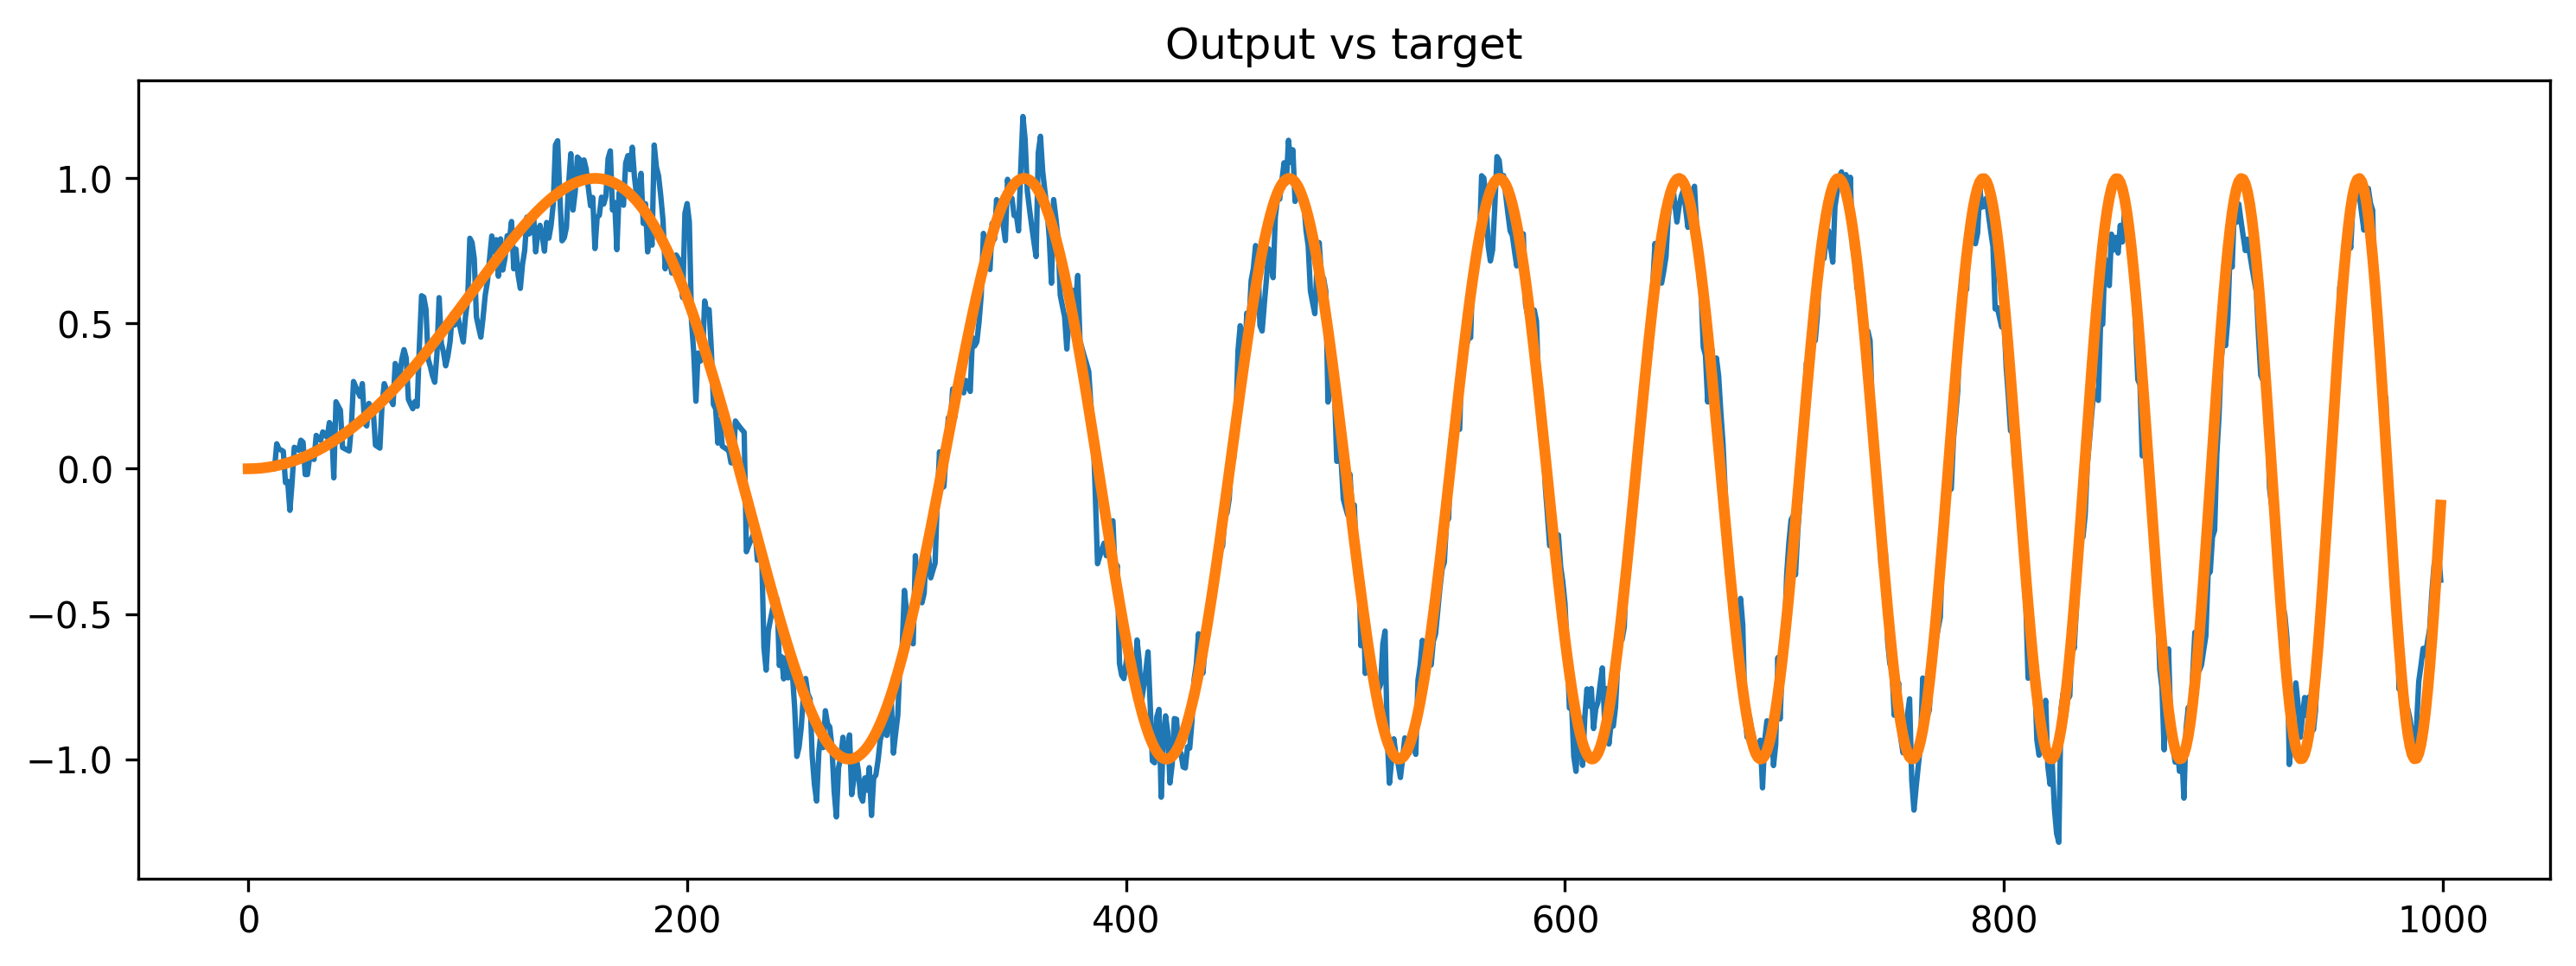

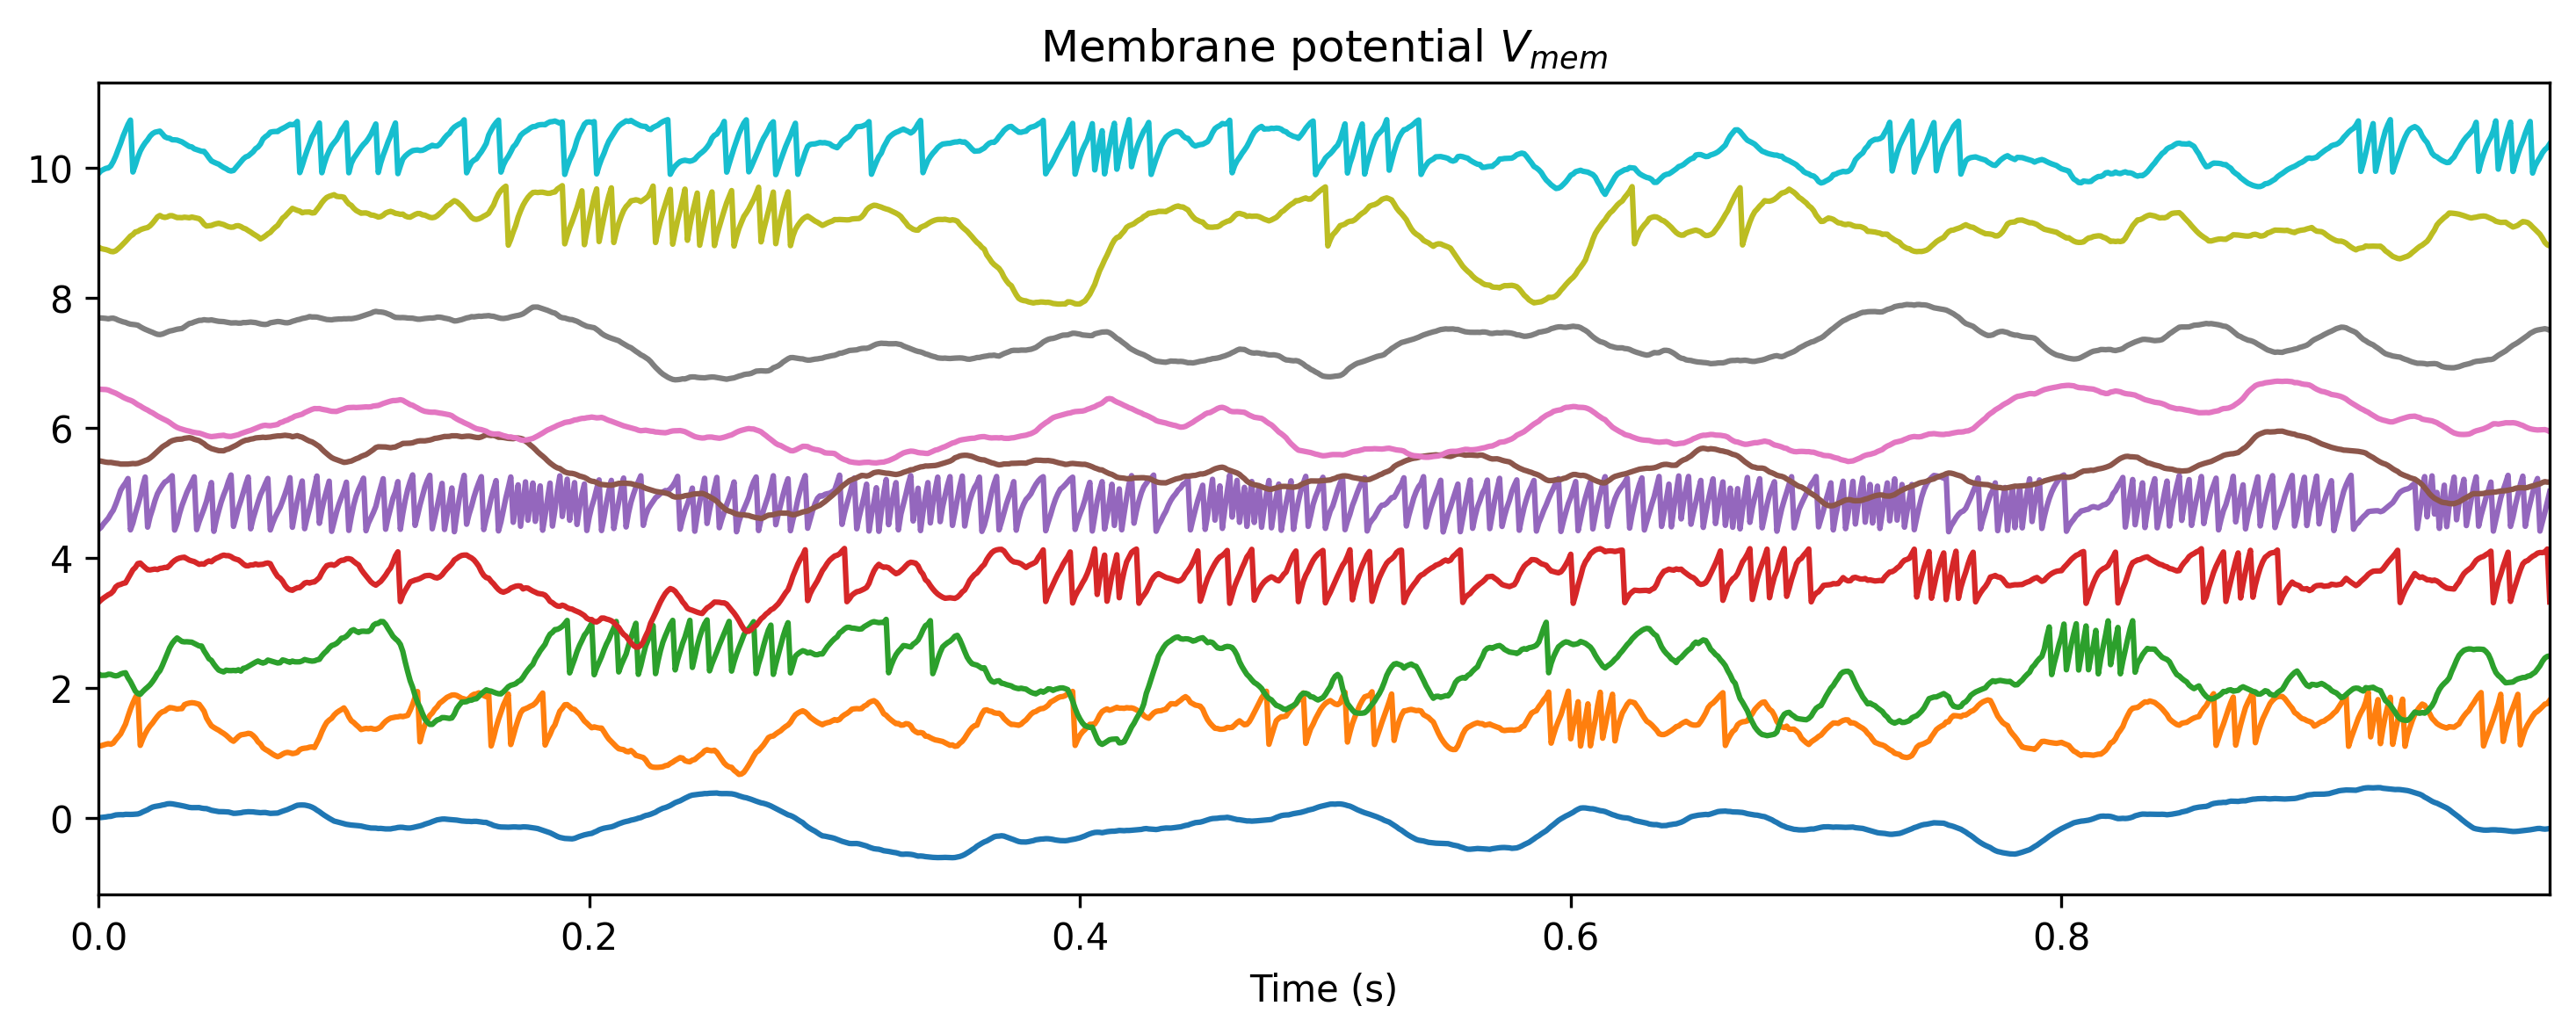

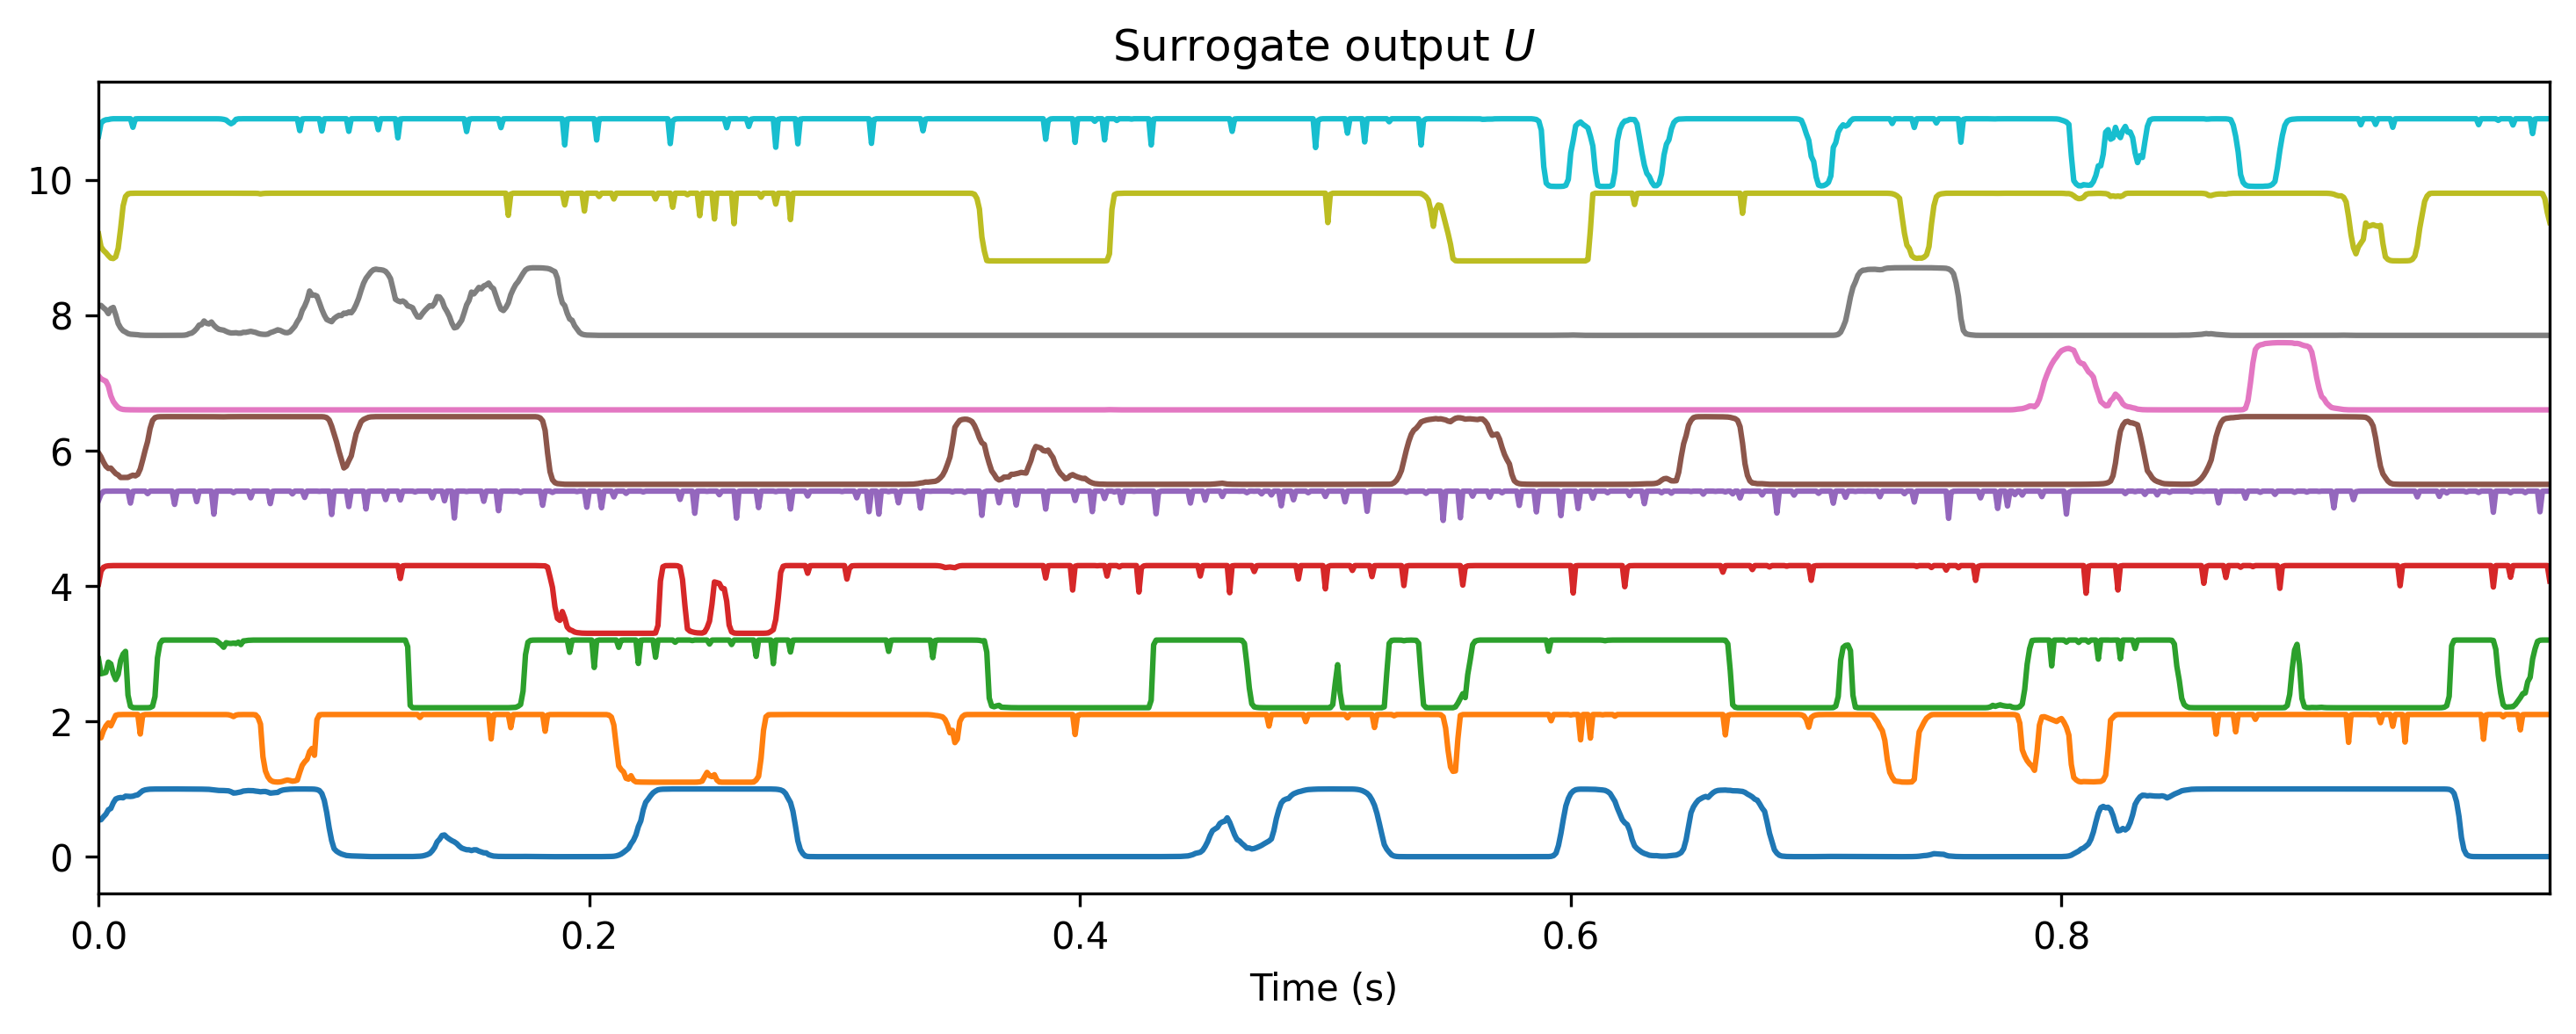

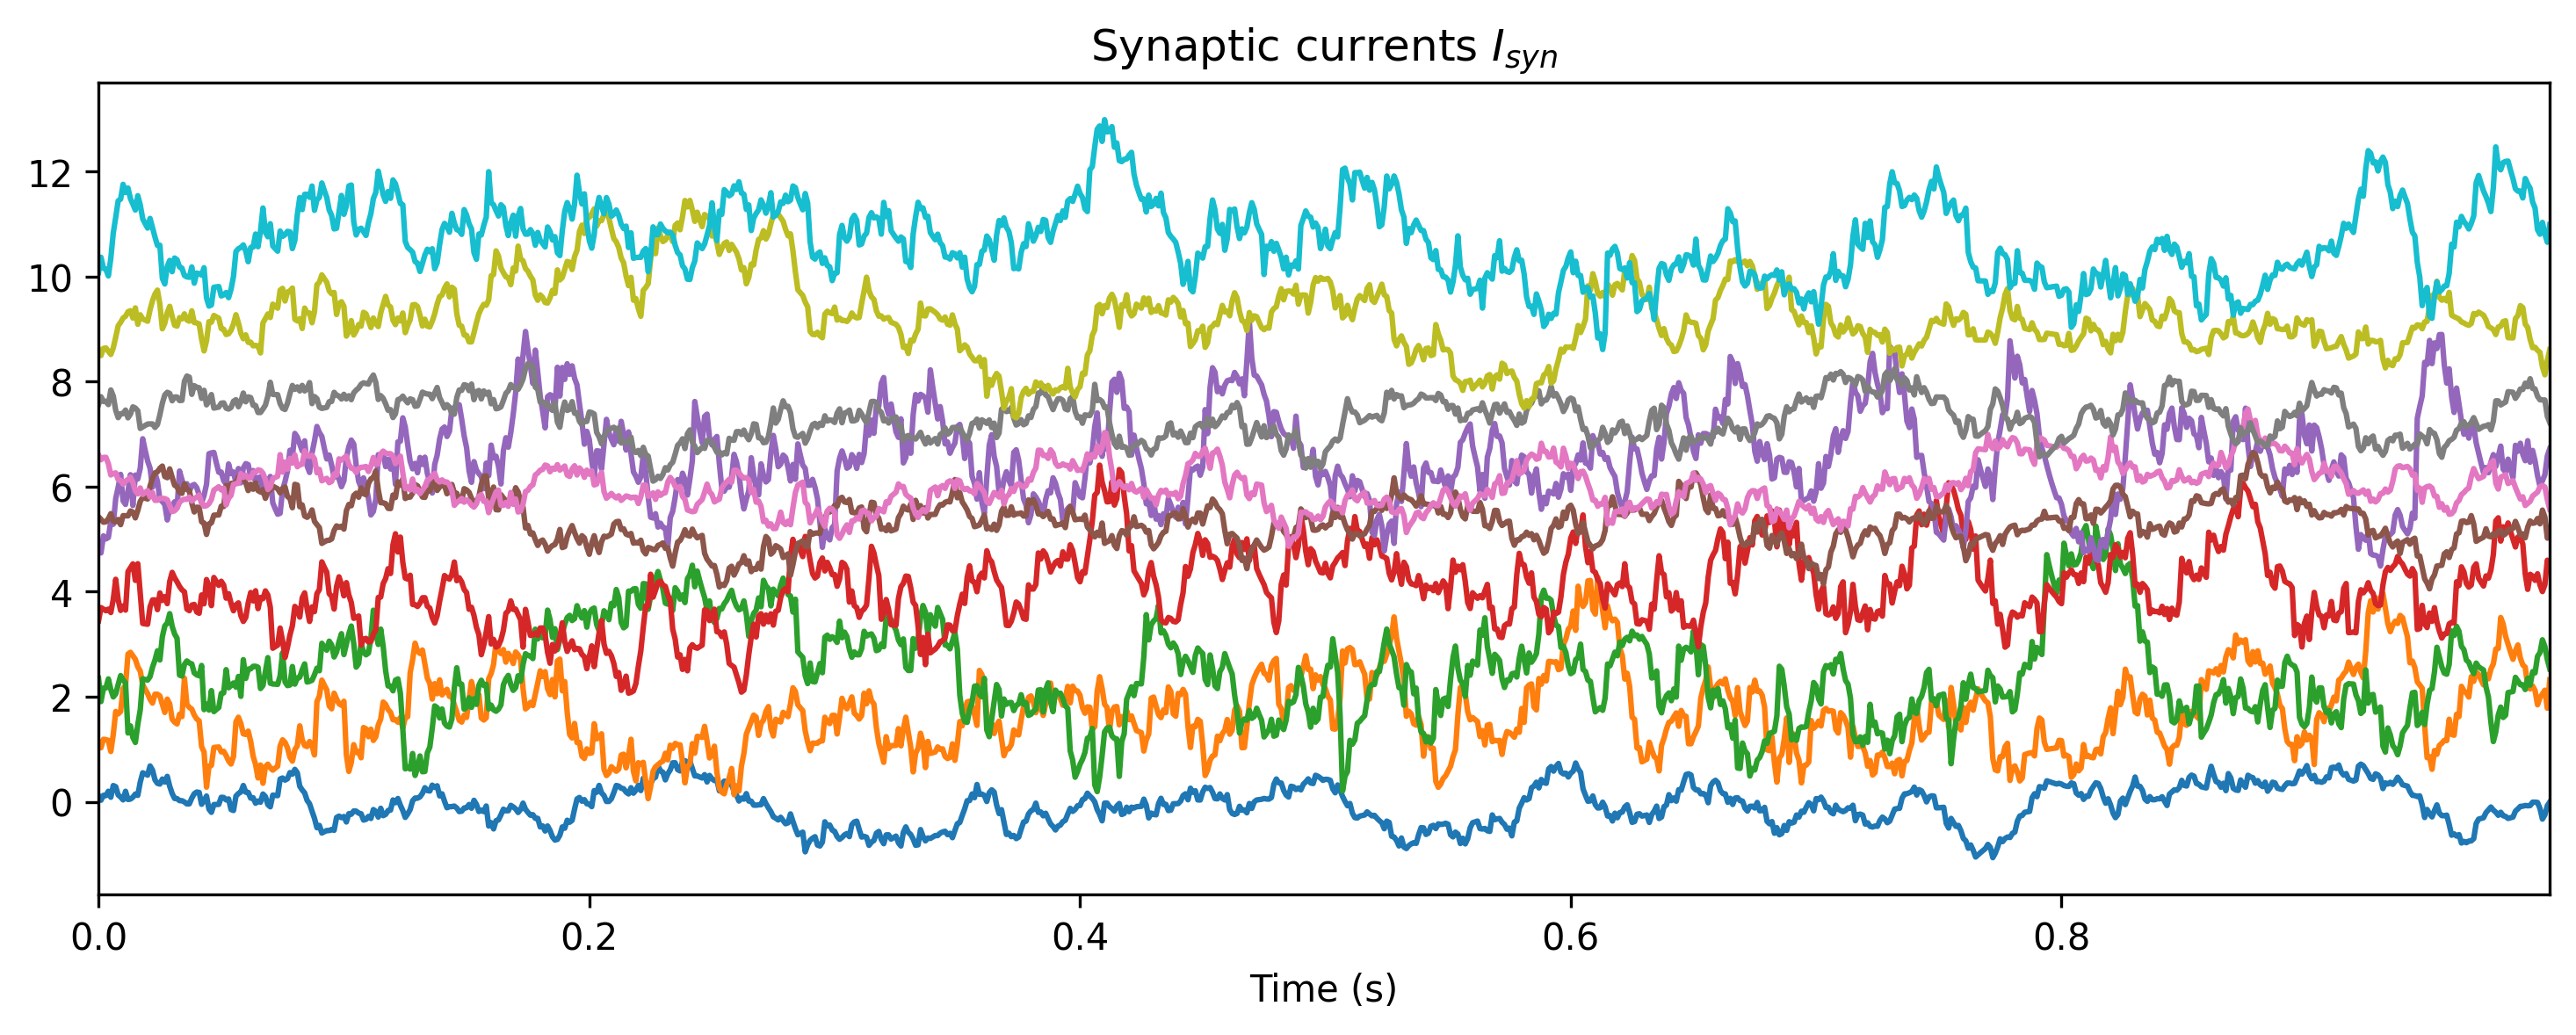

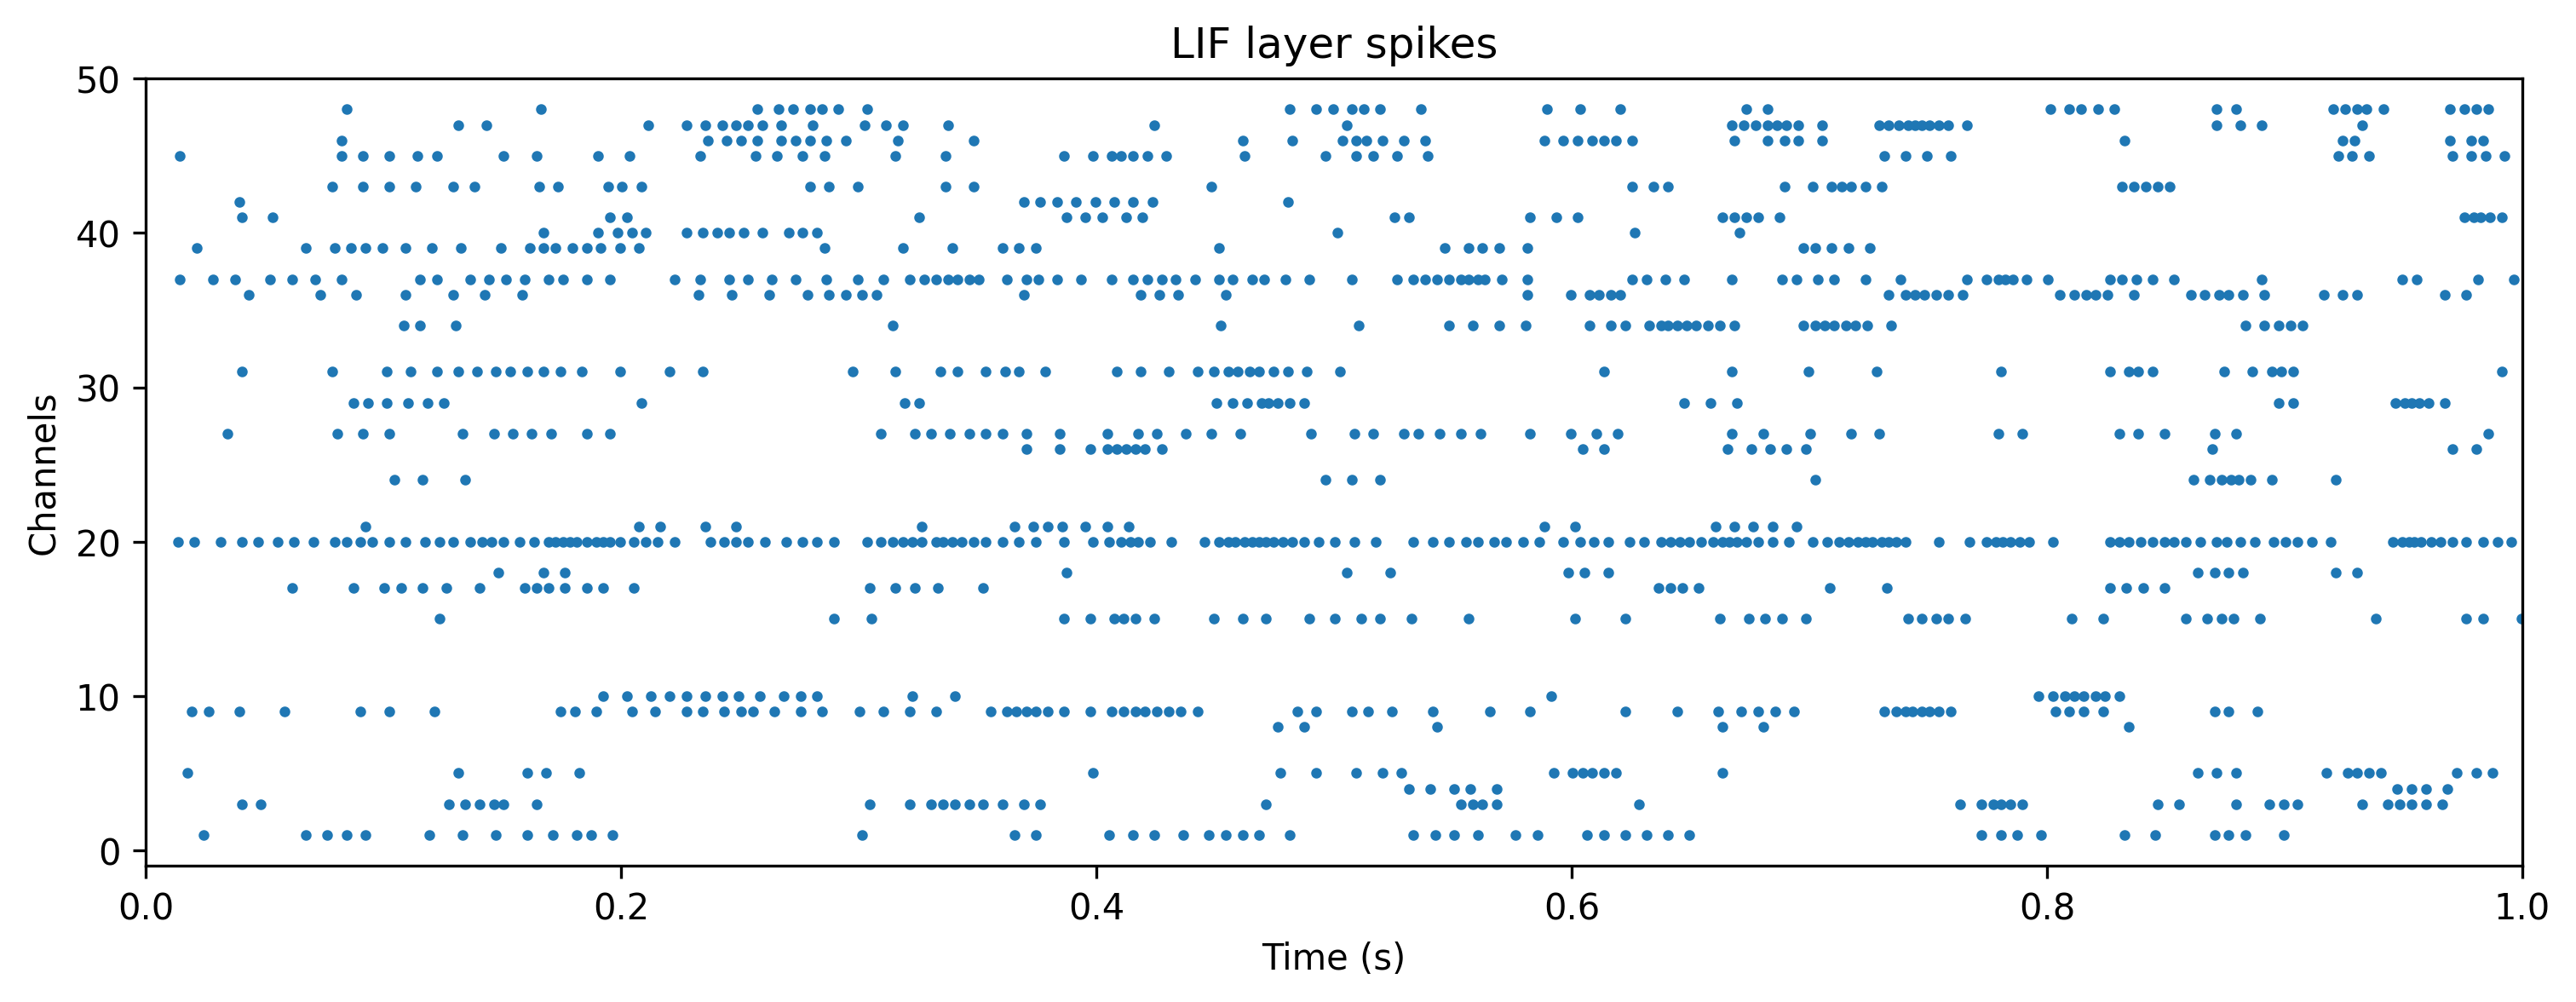

In [25]:
# - Simulate with trained parameters
modFFwd = modFFwd.set_attributes(get_params(opt_state))
modFFwd = modFFwd.reset_state()
output_ts, _, record_dict = modFFwd(input_sp_raster * input_scale)

# - Compare the output to the target
plt.plot(output_ts[0])
plt.plot(chirp, lw=3)
plt.title('Output vs target')

# - Plot the internal state of selected neurons
plot_record_dict(record_dict)